In [15]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import combinations

import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

DOWNSAMPLING_COLORS = {
    'Decimate': '#0072B2', # Blue
    'M4': '#D55E00', # Vermilion
    'MinMax': '#009E73', # Bluish green 
    'LTTB': '#CC79A7', # Reddish purple
    'MinMaxLTTB': '#E69F00', # Orange
    'Original': 'black'
}

data_dir = '../results'
downsampled_dir = f'../results/downsampled'
classification_dir = f'../results/classification'
preprocessed_dir = f'../results/preprocessed'

In [19]:
def load_distance_metrics_full(downsampled_dir):
    rows = []
    downsamplers = os.listdir(downsampled_dir)
    downsamplers.remove('.downsampling_done')

    for downsampler in downsamplers:
        current_dir = f'{downsampled_dir}/{downsampler}'
        for file in os.listdir(current_dir):
            if not file.endswith(".pkl"):
                continue

            base = file.replace(".pkl", "")
            factor = int(base.split("_")[-1])

            with open(os.path.join(current_dir, file), "rb") as f:
                metrics = pickle.load(f)

            for metric_name, values in metrics.items():
                for i, v in enumerate(np.ravel(values)):
                    rows.append({
                        "downsampler": downsampler,
                        "factor": factor,
                        "index": i,
                        "metric": metric_name,
                        "value": v
                    })

    return pd.DataFrame(rows)

df_dist_measures = load_distance_metrics_full(downsampled_dir)
df_dist_measures

,downsampler,factor,index,metric,value
0,Decimate,10,0,pearson,0.016579
1,Decimate,10,1,pearson,0.014728
2,Decimate,10,2,pearson,0.394359
3,Decimate,10,3,pearson,0.022161
4,Decimate,10,4,pearson,0.010671
...,...,...,...,...,...
3727207,LTTB,35,2366,jsd,0.051089
3727208,LTTB,35,2367,jsd,0.094535
3727209,LTTB,35,2368,jsd,0.297752
3727210,LTTB,35,2369,jsd,0.089421


In [20]:
def aggregate_distance_metrics(df):
    agg_funcs = {
        'value': ['mean', 'std', 'median']
    }
    df_agg = df.groupby(['downsampler', 'factor', 'metric']).agg(agg_funcs).reset_index()
    df_agg.columns = ['downsampler', 'factor', 'metric', 'mean', 'std', 'median']
    return df_agg

df_dist_measures_agg = aggregate_distance_metrics(df_dist_measures)
df_dist_measures_agg

,downsampler,factor,metric,mean,std,median
0,Decimate,2,envelope_pearsonr_corr,1.639342e-03,2.477469e-03,0.000877
1,Decimate,2,euclidian_psd,2.130576e-01,7.202480e-02,0.212717
2,Decimate,2,jsd,2.318329e-03,3.964594e-03,0.001635
3,Decimate,2,kurtosis,6.239275e-01,1.988115e+01,0.041927
4,Decimate,2,ncd,1.004432e+00,1.972470e-03,1.004795
...,...,...,...,...,...,...
1567,Original,1,pearson,7.108050e-17,1.098478e-16,0.000000
1568,Original,1,rmse,0.000000e+00,0.000000e+00,0.000000
1569,Original,1,skewness,0.000000e+00,0.000000e+00,0.000000
1570,Original,1,spearman,2.678395e-17,4.750987e-17,0.000000


In [21]:
df_dist_measures_wide = df_dist_measures_agg.pivot_table(index=['downsampler', 'factor'], columns='metric', values=['mean', 'std', 'median'])
df_dist_measures_wide.columns = ['_'.join(col).strip() for col in df_dist_measures_wide.columns.values]
df_dist_measures_wide = df_dist_measures_wide.reset_index()
df_dist_measures_wide

,downsampler,factor,mean_envelope_pearsonr_corr,mean_euclidian_psd,mean_jsd,mean_kurtosis,mean_ncd,mean_nmse,mean_peak_count_delta,mean_pearson,...,std_jsd,std_kurtosis,std_ncd,std_nmse,std_peak_count_delta,std_pearson,std_rmse,std_skewness,std_spearman,std_zcr
0,Decimate,2,1.639342e-03,2.130576e-01,0.002318,0.623928,1.004432,0.003508,7345.818220,1.738337e-03,...,0.003965,19.881149,0.001972,0.005802,443.552565,2.883024e-03,3.707942,0.176307,9.131812e-03,0.006922
1,Decimate,5,2.020223e-02,3.347507e-01,0.008071,2.214002,1.007726,0.067855,11039.088148,3.538556e-02,...,0.007890,28.611700,0.003576,0.076866,879.478753,4.282244e-02,7.934069,0.320947,2.241062e-02,0.014872
2,Decimate,10,3.714392e-02,3.609589e-01,0.017425,5.504294,1.007604,0.085216,12007.459300,4.488518e-02,...,0.014482,41.935757,0.003503,0.096645,1085.574563,5.562158e-02,8.722807,0.663721,2.598770e-02,0.033662
3,Decimate,15,9.302873e-02,3.679655e-01,0.026227,7.546535,1.007729,0.262021,12264.120624,1.449939e-01,...,0.021907,48.261106,0.003582,0.152352,1151.029450,9.674935e-02,14.242044,0.893998,5.264599e-02,0.048366
4,Decimate,20,1.066674e-01,3.734171e-01,0.035035,9.006806,1.007490,0.259585,12375.547448,1.447721e-01,...,0.028901,50.452763,0.003508,0.149695,1175.484909,9.590613e-02,14.170486,0.997662,5.345003e-02,0.060401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,MinMaxLTTB,300,6.251046e-01,4.277839e-01,1.225606,18.058123,0.997281,6.513394,12798.233235,8.384873e-01,...,0.818145,53.746768,0.000597,4.539297,1182.194231,1.840254e-01,72.904791,1.131559,1.960410e-01,0.153809
127,MinMaxLTTB,400,6.876936e-01,4.331533e-01,1.589359,18.880297,0.997981,8.085537,12814.288908,8.660878e-01,...,1.057232,54.594922,0.000524,5.883896,1182.465347,1.781305e-01,82.207360,1.220068,1.895668e-01,0.148118
128,MinMaxLTTB,500,7.355117e-01,4.376549e-01,1.915747,19.429891,0.998369,9.567634,12823.973429,8.846671e-01,...,1.277790,55.131805,0.000456,7.250486,1182.567001,1.693149e-01,90.245505,1.291105,1.800880e-01,0.144938
129,MinMaxLTTB,1000,8.542365e-01,4.485290e-01,3.029408,20.518423,0.999174,15.135144,12843.111767,9.215313e-01,...,2.056816,56.213035,0.000285,13.181975,1182.612479,1.494481e-01,119.046621,1.500850,1.555105e-01,0.137987


In [22]:
df_class_metrics = pd.read_csv(f'{classification_dir}/metrics_raw.csv')
df_class_metrics

,downsampler,factor,fold,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo,sensitivity_class_0,specificity_class_0,sensitivity_class_1,specificity_class_1,sensitivity_class_2,specificity_class_2
0,Original,1,1,0.907563,0.891296,0.919520,0.870270,0.981637,0.982400,0.836735,0.978836,0.977778,0.844660,0.796296,0.989130
1,Original,1,2,0.898734,0.882574,0.901362,0.868610,0.983381,0.986077,0.714286,0.968085,0.948148,0.843137,0.943396,0.989130
2,Original,1,3,0.907173,0.893089,0.919582,0.873322,0.987222,0.988329,0.857143,0.978723,0.970370,0.843137,0.792453,0.989130
3,Original,1,4,0.945148,0.940476,0.946579,0.934773,0.988119,0.989204,0.897959,0.984043,0.962963,0.921569,0.943396,0.989130
4,Original,1,5,0.932489,0.926134,0.943344,0.911571,0.986300,0.987715,0.877551,0.984043,0.970370,0.882353,0.886792,0.994565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,MinMaxLTTB,1000,6,0.734177,0.667801,0.763795,0.645735,0.878342,0.889507,0.693878,0.941489,0.903704,0.529412,0.339623,0.978261
1306,MinMaxLTTB,1000,7,0.721519,0.636441,0.730519,0.615741,0.879807,0.892295,0.625000,0.947090,0.925926,0.509804,0.296296,0.967213
1307,MinMaxLTTB,1000,8,0.696203,0.640031,0.665904,0.639660,0.861575,0.878337,0.770833,0.915344,0.814815,0.578431,0.333333,0.928962
1308,MinMaxLTTB,1000,9,0.725738,0.668515,0.738950,0.640432,0.852655,0.868385,0.625000,0.952381,0.888889,0.529412,0.407407,0.956284


In [23]:
def aggregate_classification_metrics(df):
    agg_funcs = {
        'accuracy': ['mean'],
        'f1': ['mean'],
        'roc_auc_ovr': ['mean'],
        'roc_auc_ovo': ['mean']
    }
    df_agg = df.groupby(['downsampler', 'factor']).agg(agg_funcs).reset_index()
    df_agg.columns = ['downsampler', 'factor', 'accuracy_mean', 'f1_mean', 'roc_auc_ovr_mean', 'roc_auc_ovo_mean']
    return df_agg
df_class_agg = aggregate_classification_metrics(df_class_metrics)
df_class_agg

,downsampler,factor,accuracy_mean,f1_mean,roc_auc_ovr_mean,roc_auc_ovo_mean
0,Decimate,2,0.924086,0.914098,0.987587,0.988802
1,Decimate,5,0.920718,0.909879,0.988755,0.990003
2,Decimate,10,0.912281,0.900242,0.986235,0.987906
3,Decimate,15,0.908481,0.896754,0.985366,0.987079
4,Decimate,20,0.907212,0.895464,0.983695,0.985564
...,...,...,...,...,...,...
126,MinMaxLTTB,300,0.769737,0.719877,0.908521,0.915709
127,MinMaxLTTB,400,0.756239,0.704243,0.900849,0.909197
128,MinMaxLTTB,500,0.748213,0.689342,0.891107,0.900069
129,MinMaxLTTB,1000,0.717005,0.654053,0.859365,0.872373


In [24]:
df = pd.merge(df_dist_measures_wide, df_class_agg, on=['downsampler', 'factor'])
df

,downsampler,factor,mean_envelope_pearsonr_corr,mean_euclidian_psd,mean_jsd,mean_kurtosis,mean_ncd,mean_nmse,mean_peak_count_delta,mean_pearson,...,std_peak_count_delta,std_pearson,std_rmse,std_skewness,std_spearman,std_zcr,accuracy_mean,f1_mean,roc_auc_ovr_mean,roc_auc_ovo_mean
0,Decimate,2,1.639342e-03,2.130576e-01,0.002318,0.623928,1.004432,0.003508,7345.818220,1.738337e-03,...,443.552565,2.883024e-03,3.707942,0.176307,9.131812e-03,0.006922,0.924086,0.914098,0.987587,0.988802
1,Decimate,5,2.020223e-02,3.347507e-01,0.008071,2.214002,1.007726,0.067855,11039.088148,3.538556e-02,...,879.478753,4.282244e-02,7.934069,0.320947,2.241062e-02,0.014872,0.920718,0.909879,0.988755,0.990003
2,Decimate,10,3.714392e-02,3.609589e-01,0.017425,5.504294,1.007604,0.085216,12007.459300,4.488518e-02,...,1085.574563,5.562158e-02,8.722807,0.663721,2.598770e-02,0.033662,0.912281,0.900242,0.986235,0.987906
3,Decimate,15,9.302873e-02,3.679655e-01,0.026227,7.546535,1.007729,0.262021,12264.120624,1.449939e-01,...,1151.029450,9.674935e-02,14.242044,0.893998,5.264599e-02,0.048366,0.908481,0.896754,0.985366,0.987079
4,Decimate,20,1.066674e-01,3.734171e-01,0.035035,9.006806,1.007490,0.259585,12375.547448,1.447721e-01,...,1175.484909,9.590613e-02,14.170486,0.997662,5.345003e-02,0.060401,0.907212,0.895464,0.983695,0.985564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,MinMaxLTTB,300,6.251046e-01,4.277839e-01,1.225606,18.058123,0.997281,6.513394,12798.233235,8.384873e-01,...,1182.194231,1.840254e-01,72.904791,1.131559,1.960410e-01,0.153809,0.769737,0.719877,0.908521,0.915709
127,MinMaxLTTB,400,6.876936e-01,4.331533e-01,1.589359,18.880297,0.997981,8.085537,12814.288908,8.660878e-01,...,1182.465347,1.781305e-01,82.207360,1.220068,1.895668e-01,0.148118,0.756239,0.704243,0.900849,0.909197
128,MinMaxLTTB,500,7.355117e-01,4.376549e-01,1.915747,19.429891,0.998369,9.567634,12823.973429,8.846671e-01,...,1182.567001,1.693149e-01,90.245505,1.291105,1.800880e-01,0.144938,0.748213,0.689342,0.891107,0.900069
129,MinMaxLTTB,1000,8.542365e-01,4.485290e-01,3.029408,20.518423,0.999174,15.135144,12843.111767,9.215313e-01,...,1182.612479,1.494481e-01,119.046621,1.500850,1.555105e-01,0.137987,0.717005,0.654053,0.859365,0.872373


In [25]:
def create_pairwise_data(df_subset, dist_metrics):
    pairs = list(combinations(range(len(df_subset)), 2))
    X_pairs = []
    y_pairs = []
    raw_pairs = []

    for i, j in pairs:
        first = df_subset.iloc[i]
        second = df_subset.iloc[j]
        label = 1 if first['roc_auc_ovr_mean'] > second['roc_auc_ovr_mean'] else 0
        features = first[dist_metrics] - second[dist_metrics]

        X_pairs.append(features)
        y_pairs.append(label)
        raw_pairs.append((i, j))  # keep track for later wins
        
    return np.array(X_pairs), np.array(y_pairs), raw_pairs

dist_metrics = [col for col in df.columns if col.startswith(('mean_'))]

n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_true_ranks = []
all_predicted_ranks = []
all_y_test = []
all_y_pred = []
correlations = []

dist_metrics = [col for col in df.columns if col.startswith('mean_')]
print(f"Running {n_splits}-fold cross-validation...")

all_shap_values = []
all_test_data = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"Fold {fold_idx + 1}/{n_splits}")
    
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)

    X_train, y_train, _ = create_pairwise_data(df_train, dist_metrics)
    X_test, y_test, test_pairs = create_pairwise_data(df_test, dist_metrics)

    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
    
    print("Training model...")
    model = XGBClassifier(n_estimators=1000, random_state=42)
    model.fit(X_train, y_train)

    print("Computing SHAP values...")
    explainer = shap.TreeExplainer(model, feature_names=dist_metrics)
    shap_values = explainer.shap_values(X_test)
    
    all_shap_values.append(shap_values)
    all_test_data.append(X_test)

    wins = defaultdict(int)
    y_pred = []

    print("Making predictions...")
    for (i, j), actual_label in zip(test_pairs, y_test):
        first = df_test.iloc[i]
        second = df_test.iloc[j]
        features = first[dist_metrics] - second[dist_metrics]
        pred = model.predict([features])[0]
        y_pred.append(pred)
        
        if pred == 1:
            wins[j] += 1
        else:
            wins[i] += 1
    
    df_test['wins'] = [wins[i] for i in range(len(df_test))]
    df_test['predicted_rank'] = df_test['wins'].rank(ascending=False)
    df_test['true_rank_test'] = df_test['roc_auc_ovr_mean'].rank(ascending=True)
    
    all_true_ranks.extend(df_test['true_rank_test'].values)
    all_predicted_ranks.extend(df_test['predicted_rank'].values)
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    
all_true_ranks = np.array(all_true_ranks)
all_predicted_ranks = np.array(all_predicted_ranks)
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)

print("Aggregating SHAP values across folds...")
aggregated_shap_values = np.vstack(all_shap_values)
aggregated_test_data = np.vstack(all_test_data)

Running 2-fold cross-validation...
Fold 1/2
Training set size: 2080, Test set size: 2145
Training model...
Computing SHAP values...
Making predictions...
Fold 2/2
Training set size: 2145, Test set size: 2080
Training model...
Computing SHAP values...
Making predictions...
Aggregating SHAP values across folds...


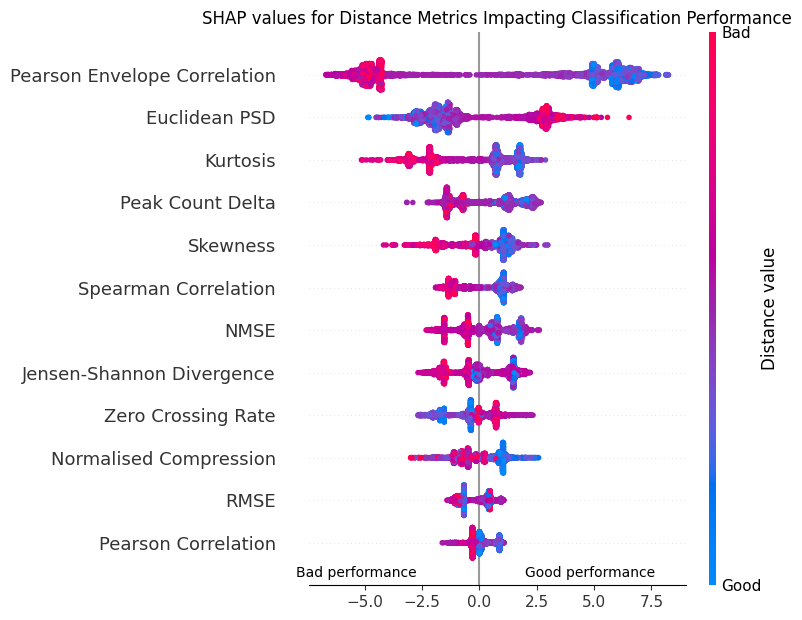

In [26]:
feature_name_mapping = {
    'mean_envelope_pearsonr_corr': 'Pearson Envelope Correlation',
    'mean_euclidian_psd': 'Euclidean PSD',
    'mean_peak_count_delta': 'Peak Count Delta',
    'mean_ncd': 'Normalised Compression',
    'mean_pearson': 'Pearson Correlation',
    'mean_spearman': 'Spearman Correlation',
    'mean_zcr': 'Zero Crossing Rate',
    'mean_skewness': 'Skewness',
    'mean_nmse': 'NMSE',
    'mean_rmse': 'RMSE',
    'mean_kurtosis': 'Kurtosis',
    'mean_jsd': 'Jensen-Shannon Divergence'
}

new_feature_names = [feature_name_mapping.get(name, name) for name in dist_metrics]

plt.figure(figsize=(10, 8))
shap.summary_plot(aggregated_shap_values, aggregated_test_data, feature_names=new_feature_names, show=False, color_bar_label="Distance value")

cb = plt.gcf().axes[-1]
cb.set_yticklabels(['Good', 'Bad'])

plt.text(2, -0.8, "Good performance")
plt.text(-8, -0.8, "Bad performance")

plt.gca().set_title('')
plt.xlabel('')
plt.title('SHAP values for Distance Metrics Impacting Classification Performance')

plt.tight_layout()
plt.show()

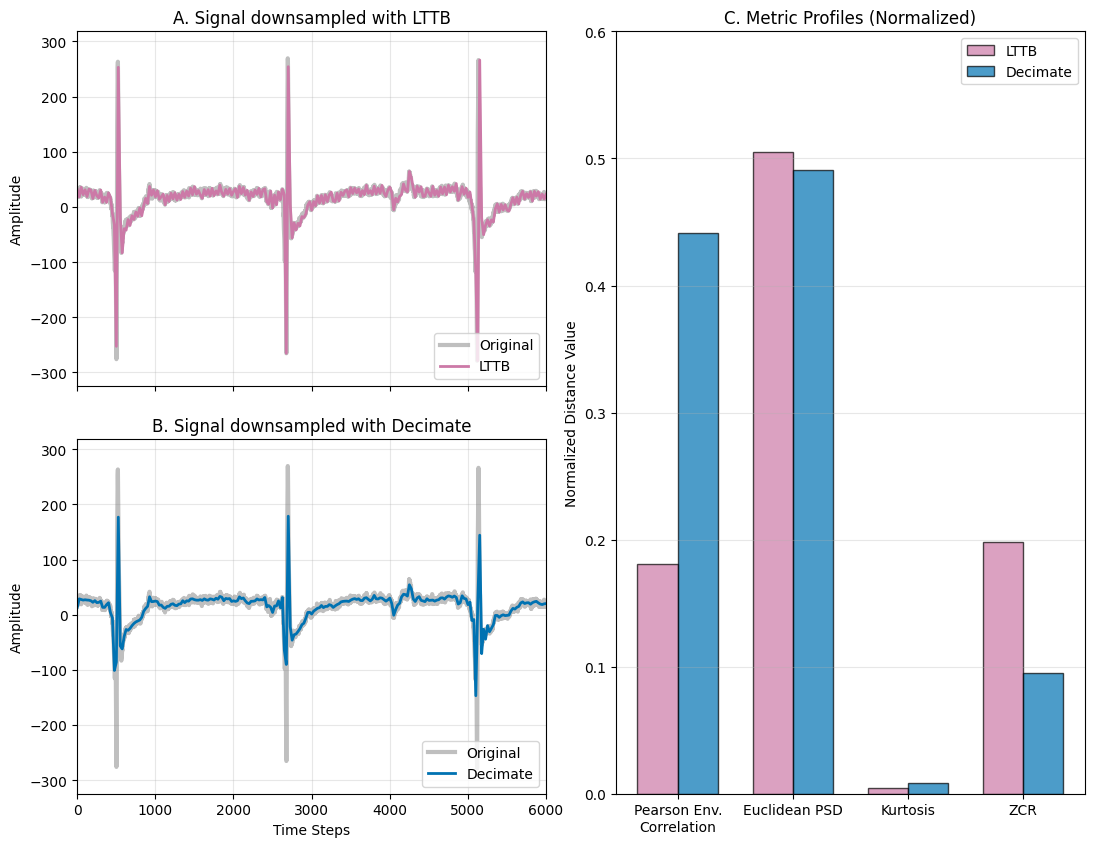

In [ ]:
def load_data_and_metrics_normalized(df, downsampler, sig_idx):
    downsampled = np.load(f'{downsampled_dir}/{downsampler}/X_25.npy')[sig_idx]
    pattern = df[(df['index'] == sig_idx) & (df['downsampler'] == downsampler)].iloc[0]
    return downsampled, pattern   

def plot_measure_tradeoff(df_dist_measures, original_signals, good_downsampler='LTTB', bad_downsampler='Decimate'):
    pivot = df_dist_measures.pivot_table(index=['index', 'downsampler'], columns='metric', values='value').reset_index()
    all_metrics = ['envelope_pearsonr_corr', 'euclidian_psd', 'kurtosis', 'zcr']
    
    normalization_params = {}
    for metric in all_metrics:
        metric_values = df_dist_measures[df_dist_measures['metric'] == metric]['value']
        
        min_val = metric_values.min()
        max_val = metric_values.max()
        
        if min_val == max_val:
            normalization_params[metric] = (min_val, max_val, 1)
        else:
            normalization_params[metric] = (min_val, max_val, max_val - min_val)

    
    normalized_pivot = pivot.copy()
    for metric in all_metrics:
        min_val, _, range_val = normalization_params[metric]
        normalized_pivot[metric] = (normalized_pivot[metric] - min_val) / range_val

    good_ds_data = normalized_pivot[normalized_pivot['downsampler'] == good_downsampler].copy()
    bad_ds_data = normalized_pivot[normalized_pivot['downsampler'] == bad_downsampler].copy()
    selection_metrics = ['envelope_pearsonr_corr', 'zcr']
    good_ds_data['Norm_Distance_Sum'] = good_ds_data[selection_metrics].sum(axis=1)
    bad_ds_data['Norm_Distance_Sum'] = bad_ds_data[selection_metrics].sum(axis=1)
    merged = good_ds_data[['index', 'Norm_Distance_Sum']].merge(
        bad_ds_data[['index', 'Norm_Distance_Sum']],
        on='index',
        suffixes=('_good', '_bad')
    )
    
    merged['contrast'] = merged['Norm_Distance_Sum_bad'] - merged['Norm_Distance_Sum_good']
    best_contrast = merged.sort_values('contrast', ascending=False).iloc[0]
    sig_idx = int(best_contrast['index'])
    original = original_signals[sig_idx]

    good_downsampled, good_pattern = load_data_and_metrics_normalized(normalized_pivot, good_downsampler, sig_idx)
    bad_downsampled, bad_pattern = load_data_and_metrics_normalized(normalized_pivot, bad_downsampler, sig_idx)

    t = np.arange(len(original))
    t_good_ds = np.linspace(0, len(original)-1, len(good_downsampled))
    t_bad_ds = np.linspace(0, len(original)-1, len(bad_downsampled))
    fig = plt.figure(figsize=(13, 9.9))
    gs = fig.add_gridspec(2, 2, wspace=0.15, hspace=0.15, width_ratios=[1, 1.0])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t, original, label='Original', linewidth=3, alpha=0.5, color='grey')
    ax1.plot(t_good_ds, good_downsampled, label=f'{good_downsampler}', color=DOWNSAMPLING_COLORS[good_downsampler], linewidth=2)
    ax1.set_title(f"A. Signal downsampled with {good_downsampler}")
    ax1.set_ylabel('Amplitude')
    ax1.legend(loc='lower right')
    ax1.set_xlim(0, 6000)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', labelbottom=False)

    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(t, original, label='Original', linewidth=3, alpha=0.5, color='grey')
    ax2.plot(t_bad_ds, bad_downsampled, label=f'{bad_downsampler}', color=DOWNSAMPLING_COLORS[bad_downsampler], linewidth=2)
    ax2.set_title(f"B. Signal downsampled with {bad_downsampler}")
    ax2.set_ylabel('Amplitude')
    ax2.set_xlabel('Time Steps')
    ax2.legend(loc='lower right')
    ax2.set_xlim(0, 6000)
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[:, 1])
    
    metrics_to_plot = all_metrics
    metric_labels = ['Pearson Env.\nCorrelation', 'Euclidean PSD', 'Kurtosis', 'ZCR']
    
    good_values = [good_pattern.get(m, 0) for m in metrics_to_plot]
    bad_values = [bad_pattern.get(m, 0) for m in metrics_to_plot]

    x = np.arange(len(metrics_to_plot))
    width = 0.35

    ax3.bar(x - width/2, good_values, width, label=good_downsampler,  color=DOWNSAMPLING_COLORS[good_downsampler], alpha=0.7, edgecolor='black')
    ax3.bar(x + width/2, bad_values, width, label=bad_downsampler, color=DOWNSAMPLING_COLORS[bad_downsampler], alpha=0.7, edgecolor='black')

    ax3.set_title(f"C. Metric Profiles (Normalized)")
    ax3.set_ylabel('Normalized Distance Value')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metric_labels, fontsize=10)
    ax3.legend()
    ax3.set_ylim(0, 0.6) 
    ax3.grid(True, alpha=0.3, axis='y')

    plt.show()

    return sig_idx, best_contrast

original_signals = np.load(f'{preprocessed_dir}/X.npy')
original_signals = {i: original_signals[i] for i in range(original_signals.shape[0])}
sig_idx, contrast_data = plot_measure_tradeoff(df_dist_measures, original_signals, good_downsampler='LTTB',bad_downsampler='Decimate')

In [28]:

accuracy = accuracy_score(all_y_test, all_y_pred)
precision = precision_score(all_y_test, all_y_pred)
recall = recall_score(all_y_test, all_y_pred)
f1 = f1_score(all_y_test, all_y_pred)
roc_auc = roc_auc_score(all_y_test, all_y_pred)

print("Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Classification Metrics:
Accuracy: 0.9749
Precision: 0.9718
Recall: 0.9834
F1 Score: 0.9776
ROC AUC: 0.9738


Total pairs: 8,515


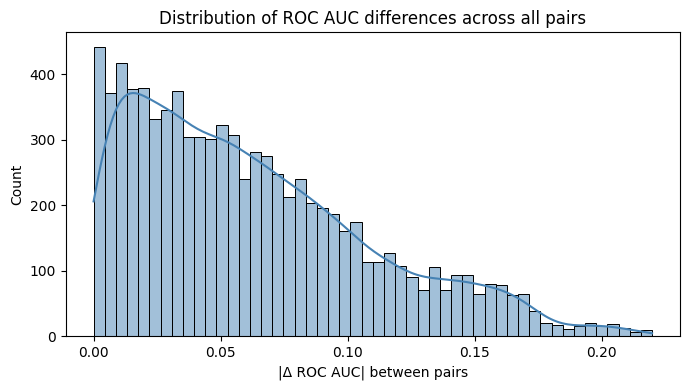

In [29]:
auc_diffs = []
for i, j in combinations(range(len(df)), 2):
    diff = abs(df.iloc[i]['accuracy_mean'] - df.iloc[j]['accuracy_mean'])
    auc_diffs.append(diff)

auc_diffs = np.array(auc_diffs)
print(f"Total pairs: {len(auc_diffs):,}")

plt.figure(figsize=(7,4))
sns.histplot(auc_diffs, bins=50, kde=True, color='steelblue')
plt.xlabel('|Δ ROC AUC| between pairs')
plt.ylabel('Count')
plt.title('Distribution of ROC AUC differences across all pairs')
plt.tight_layout()
plt.show()

In [30]:
def weighted_pairwise_accuracy_exp(df_test, test_pairs, y_test, y_pred, lam=10):
    diffs = np.array([abs(df_test.iloc[i]['roc_auc_ovr_mean'] - df_test.iloc[j]['roc_auc_ovr_mean'])for (i, j) in test_pairs])
    correct = np.array([int(yt == yp) for yt, yp in zip(y_test, y_pred)])

    weights = np.exp(-lam * diffs)

    weighted_acc = np.sum(weights * correct) / np.sum(weights)
    return weighted_acc

for lam in [5, 10, 20, 30]:
    print(f"lamb={lam}: {weighted_pairwise_accuracy_exp(df_test, test_pairs, y_test, y_pred, lam):.4f}")

lamb=5: 0.9693
lamb=10: 0.9650
lamb=20: 0.9566
lamb=30: 0.9484


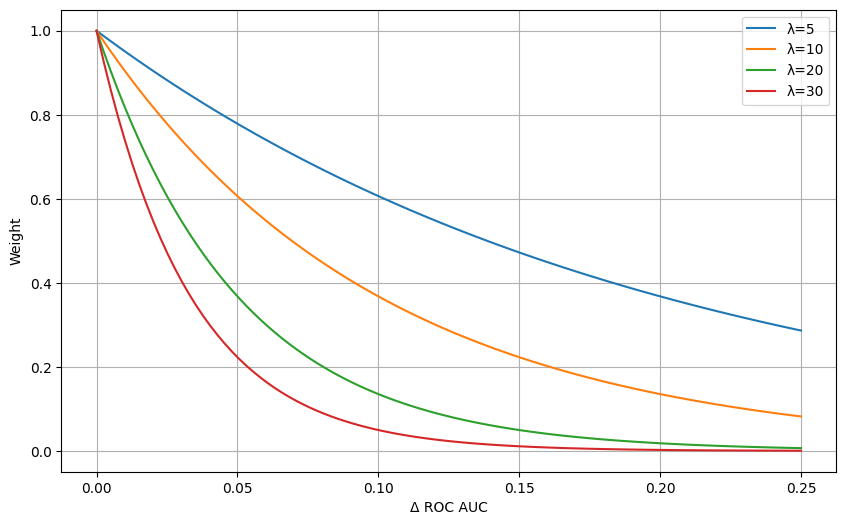

In [31]:
delta_auc = np.linspace(0, 0.25, 100)
lambdas = [5, 10, 20, 30]
plt.figure(figsize=(10,6))
for lam in lambdas:
    weights_exp = np.exp(-lam * delta_auc)
    plt.plot(delta_auc, weights_exp, label=f'λ={lam}')
plt.xlabel("Δ ROC AUC")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Cross-Validated Confusion Matrix (2-fold CV)')

<Figure size 600x500 with 0 Axes>

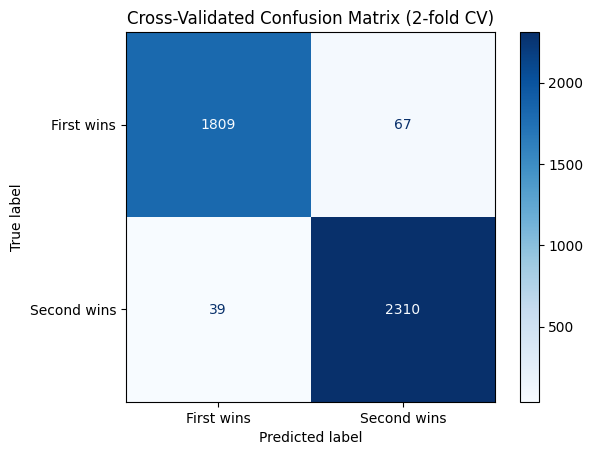

In [32]:
cm = confusion_matrix(all_y_test, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['First wins', 'Second wins'])
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title(f'Cross-Validated Confusion Matrix ({n_splits}-fold CV)')

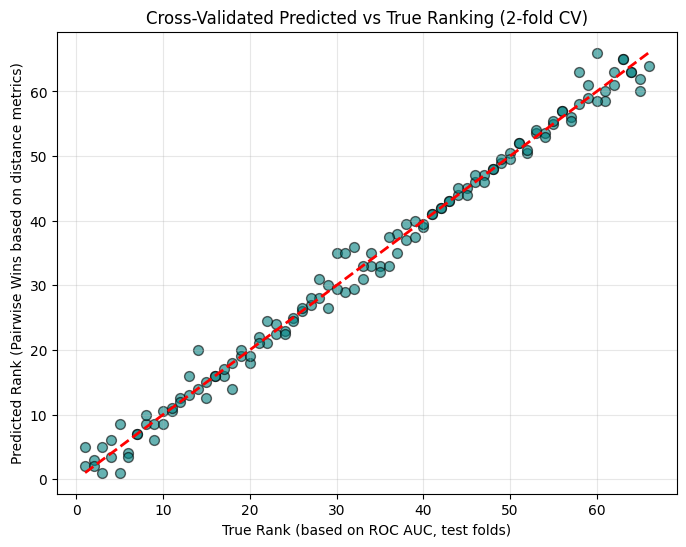

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(all_true_ranks, all_predicted_ranks, alpha=0.6, color='teal', edgecolor='black', s=50)
plt.plot([all_true_ranks.min(), all_true_ranks.max()], [all_true_ranks.min(), all_true_ranks.max()], 'r--', linewidth=2)
plt.xlabel('True Rank (based on ROC AUC, test folds)')
plt.ylabel('Predicted Rank (Pairwise Wins based on distance metrics)')
plt.title(f'Cross-Validated Predicted vs True Ranking ({n_splits}-fold CV)')
plt.grid(True, alpha=0.3)
plt.show()